In [161]:
# #@title Load Data from Dropbox
# !wget -O data_input.csv https://www.dropbox.com/s/g9xvk71iio3rcmu/single_input?dl=0 --no-hsts
# !wget -O data_output.csv https://www.dropbox.com/s/szkgat2th6x92mu/single_output?dl=0  --no-hsts

!wget -O inputs6.csv https://www.dropbox.com/sh/xepz9yd20ga22xi/AAAHDrLxSkp48pQZEpBtDnZ2a/Bandwidth%2050MHz/23GHz/5percent/CSV_Data_Bandwidth50MHz_23GHz_input_5p.csv?dl=0
!wget -O inputs7.csv https://www.dropbox.com/sh/xepz9yd20ga22xi/AACQ-nsHUkfN-mnhJfkQ1l3za/Bandwidth%2050MHz/21GHz/5percent/CSV_Data_Bandwidth50MHz_21GHz_input_5p.csv?dl=0
!wget -O inputs8.csv https://www.dropbox.com/sh/xepz9yd20ga22xi/AAAZYx7ZcbOeMUqNi_aD7BiMa/Bandwidth%2050MHz/22GHz/5percent/CSV_Data_Bandwidth50MHz_22GHz_input_5p.csv?dl=0

Will not apply HSTS. The HSTS database must be a regular and non-world-writable file.
ERROR: could not open HSTS store at '/home/anovak/.wget-hsts'. HSTS will be disabled.
--2020-09-02 15:15:17--  https://www.dropbox.com/sh/xepz9yd20ga22xi/AAAHDrLxSkp48pQZEpBtDnZ2a/Bandwidth%2050MHz/23GHz/5percent/CSV_Data_Bandwidth50MHz_23GHz_input_5p.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.66.1, 198.51.44.6, 198.51.45.6, ...
Connecting to www.dropbox.com (www.dropbox.com)|162.125.66.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/raw/xepz9yd20ga22xi/AAAHDrLxSkp48pQZEpBtDnZ2a/Bandwidth%2050MHz/23GHz/5percent/CSV_Data_Bandwidth50MHz_23GHz_input_5p.csv [following]
--2020-09-02 15:15:17--  https://www.dropbox.com/sh/raw/xepz9yd20ga22xi/AAAHDrLxSkp48pQZEpBtDnZ2a/Bandwidth%2050MHz/23GHz/5percent/CSV_Data_Bandwidth50MHz_23GHz_input_5p.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Fo

In [1]:
#@title Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import backend
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import optimizers
from scipy.signal import argrelextrema as ext
import tensorflow as tf

import chillmax as cm

In [7]:
cm.sampling

<module 'chillmax.sampling' from '/home/anovak/chillmax/chillmax/sampling.py'>

In [167]:
#@title Reading Data
dfi = pd.read_csv('data_input.csv')
#dfi[:6]
dfo = pd.read_csv('data_output.csv')
#dfo[:6]

hmm = []
for i in [6,7,8]:   
    dfi = pd.read_csv(f'inputs{i}.csv')
    hmm.append(dfi.to_numpy())
    
hmm


[array([[0.00081581, 0.00633138, 0.00655588, ..., 0.00647948, 0.00704843,
         0.        ],
        [0.00085099, 0.00638764, 0.00655367, ..., 0.00652053, 0.00707355,
         0.        ],
        [0.00080881, 0.00636441, 0.00653522, ..., 0.00650403, 0.0070626 ,
         0.        ],
        ...,
        [0.00088143, 0.00631195, 0.00661476, ..., 0.00645513, 0.00704794,
         0.        ],
        [0.00086733, 0.00635073, 0.00663247, ..., 0.00650172, 0.00699803,
         0.        ],
        [0.00084315, 0.00638273, 0.0065502 , ..., 0.00645607, 0.00709358,
         0.        ]]),
 array([[0.00752803, 0.00740849, 0.00755742, ..., 0.00718424, 0.00768392,
         0.        ],
        [0.007592  , 0.00742147, 0.00753104, ..., 0.00721109, 0.00768809,
         0.        ],
        [0.00754065, 0.00740848, 0.00753698, ..., 0.00716045, 0.0076696 ,
         0.        ],
        ...,
        [0.00751516, 0.00736973, 0.0075896 , ..., 0.00722334, 0.00772668,
         0.        ],
        [0.0

In [11]:
cfgs = dfi.to_numpy()
lfreqs = []
lcfgs = []
from tqdm import tqdm
for i, cfg in enumerate(tqdm(cfgs[:500])):
    spans = cm.sampling.get_spans(cfg)
    f, c = cm.sampling.find_split_sampling(spans, cfg)
    lfreqs.append(f)
    lcfgs.append(c)

Sfreqs = np.vstack(lfreqs)
Scfgs = np.vstack(lcfgs)

100%|██████████| 500/500 [00:15<00:00, 31.46it/s]


In [17]:
def generate(freqs, cfgs):
    boosts = []
    from tqdm import tqdm
    for i, (freq, cfg) in enumerate(tqdm(zip(freqs, cfgs))):
        boosts.append(cm.sim.boost(freq*1e9, spacings=cfg))
    return boosts
                      
boosts = generate(Sfreqs, Scfgs)

636it [00:04, 139.79it/s]


In [18]:
#@title Storing data in arrays, shuffle and split
# X = dfi.to_numpy()[:,:-1]
# y = dfo.to_numpy()
# freqs = dfo.columns.to_numpy().astype(float)

# Need to do this because shufflinf would scramble the order for 1 point predictions
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.90, shuffle=False)

In [23]:
X_train, X_test, f_train, f_test, y_train, y_test = train_test_split(Scfgs, 
                                                    Sfreqs,
                                                    boosts, 
                                                    test_size=0.1, shuffle=False)

In [35]:
y_train[1].shape

(200,)

In [30]:
#@title Reshape to predict single point
def flatten(Xs, ys, freqs):
    SIZE = np.asarray(ys).shape[0]
    NPTS = np.asarray(ys).shape[-1]
    fXs = np.empty((SIZE*NPTS, Xs.shape[-1]+1))
    for i in range(SIZE):
        fXs[i*NPTS:(i+1)*NPTS, :-1] = np.tile(Xs[i], (NPTS,1))
        fXs[i*NPTS:(i+1)*NPTS, -1] = freqs[i]
        
    fys = np.empty((SIZE*NPTS, 2))
    for i in range(SIZE):
        fys[i*NPTS:(i+1)*NPTS, 0] = freqs[i]#np.arange(NPTS)
        fys[i*NPTS:(i+1)*NPTS, 1] = ys[i]
        
    return fXs, fys

Xf_train, yf_train = flatten(X_train, y_train, f_train)
Xf_test, yf_test = flatten(X_test, y_test, f_test)

In [31]:
#@title Transform
from sklearn.preprocessing import QuantileTransformer
scalerX = QuantileTransformer()
scalerY = QuantileTransformer()
Xs_train = scalerX.fit_transform(Xf_train) 
ys_train = scalerY.fit_transform(yf_train) 

Xs_test = scalerX.transform(Xf_test) 
ys_test = scalerY.transform(yf_test) 

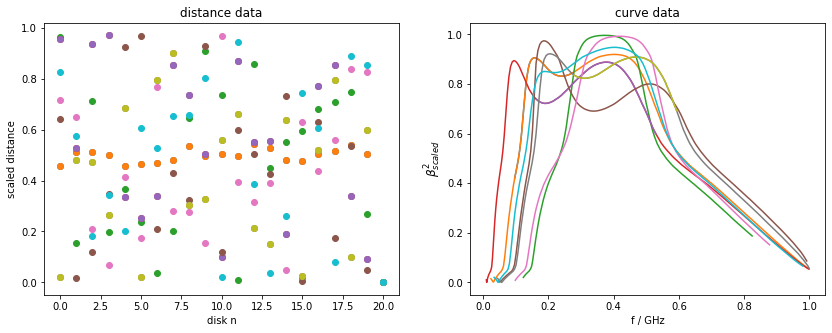

In [36]:
#@title Plot transformed
fig, axs = plt.subplots(1, 2, figsize=(14,5)) 
_size = 200
for i in range(10):    
    yax = Xs_train[i*_size:i*_size+_size][0][:-1]
    xax = range(len(yax))
    axs[0].scatter(xax, yax, label=i)
    axs[0].set_xlabel("disk n")
    axs[0].set_ylabel("scaled distance")
    xax = ys_train[i*_size:i*_size+_size][:, :-1].T[0]
    yax = ys_train[i*_size:i*_size+_size][:, -1:].T[0]
    axs[1].plot(xax, yax, label=i)
    axs[1].set_xlabel("f / GHz")
    axs[1].set_ylabel(r"$\beta^2_{scaled}$",fontsize=12)

axs[0].set_title("distance data")
axs[1].set_title("curve data");

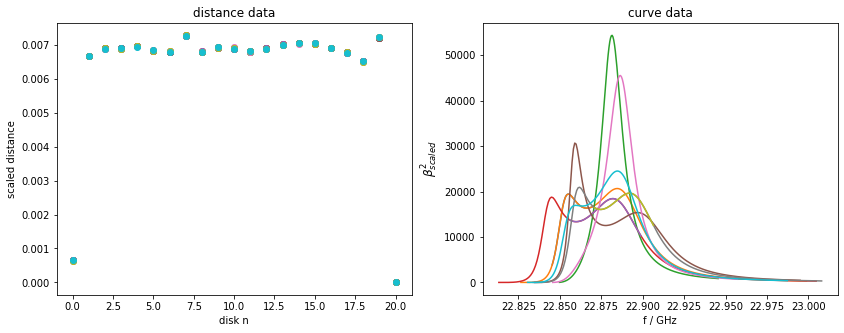

In [40]:
#@title Plot inverse transform roundtrip
fig, axs = plt.subplots(1, 2, figsize=(14,5)) 
Xsi = scalerX.inverse_transform(Xs_train)
ysi = scalerY.inverse_transform(ys_train)

for i in range(min(10, len(y))):    
    yax = Xsi[i*_size:(i+1)*_size][0][:-1]
    xax = range(len(yax))
    axs[0].scatter(xax, yax, label=i)
    axs[0].set_xlabel("disk n")
    axs[0].set_ylabel("scaled distance")
        
    xax = ysi[i*_size:(i+1)*_size][:, :-1].T[0] 
    yax = ysi[i*_size:(i+1)*_size][:, -1:].T[0]
    axs[1].plot(xax, yax, label=i)
    axs[1].set_xlabel("f / GHz")
    axs[1].set_ylabel(r"$\beta^2_{scaled}$",fontsize=12)

axs[0].set_title("distance data")
axs[1].set_title("curve data");

In [42]:
#@title Actual training
model = Sequential()
model.add(Dense(500, input_dim=22, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='linear'))


model.compile(optimizer = "adam", loss ='mse', metrics=['accuracy','mse'])

history=model.fit(Xs_train, ys_train, epochs=10, verbose=1,validation_split=0.2)

Train on 91520 samples, validate on 22880 samples
Epoch 1/10
91520/91520 [==============================] - 23s 246us/sample - loss: 0.0134 - accuracy: 0.9139 - mse: 0.0134 - val_loss: 0.0060 - val_accuracy: 0.9315 - val_mse: 0.0060
Epoch 2/10
91520/91520 [==============================] - 17s 187us/sample - loss: 0.0052 - accuracy: 0.9447 - mse: 0.0052 - val_loss: 0.0035 - val_accuracy: 0.9563 - val_mse: 0.0035
Epoch 3/10
91520/91520 [==============================] - 20s 222us/sample - loss: 0.0038 - accuracy: 0.9512 - mse: 0.0038 - val_loss: 0.0035 - val_accuracy: 0.9563 - val_mse: 0.0035
Epoch 4/10
91520/91520 [==============================] - 19s 210us/sample - loss: 0.0031 - accuracy: 0.9561 - mse: 0.0031 - val_loss: 0.0028 - val_accuracy: 0.9536 - val_mse: 0.0028
Epoch 5/10
91520/91520 [==============================] - 24s 265us/sample - loss: 0.0029 - accuracy: 0.9574 - mse: 0.0029 - val_loss: 0.0026 - val_accuracy: 0.9543 - val_mse: 0.0026
Epoch 6/10
91520/91520 [===========

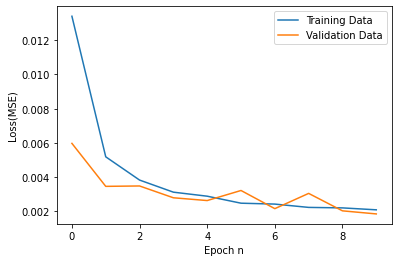

In [43]:
#@title Plot loss
plt.plot(history.history['mse'],label='Training Data')
plt.plot(history.history['val_mse'],label='Validation Data')
plt.xlabel("Epoch n")
plt.ylabel("Loss(MSE)")
plt.legend()

In [44]:
predictions = model.predict(Xs_test)

In [45]:
predi = scalerY.inverse_transform(predictions)
predi_truth = scalerY.inverse_transform(ys_test)

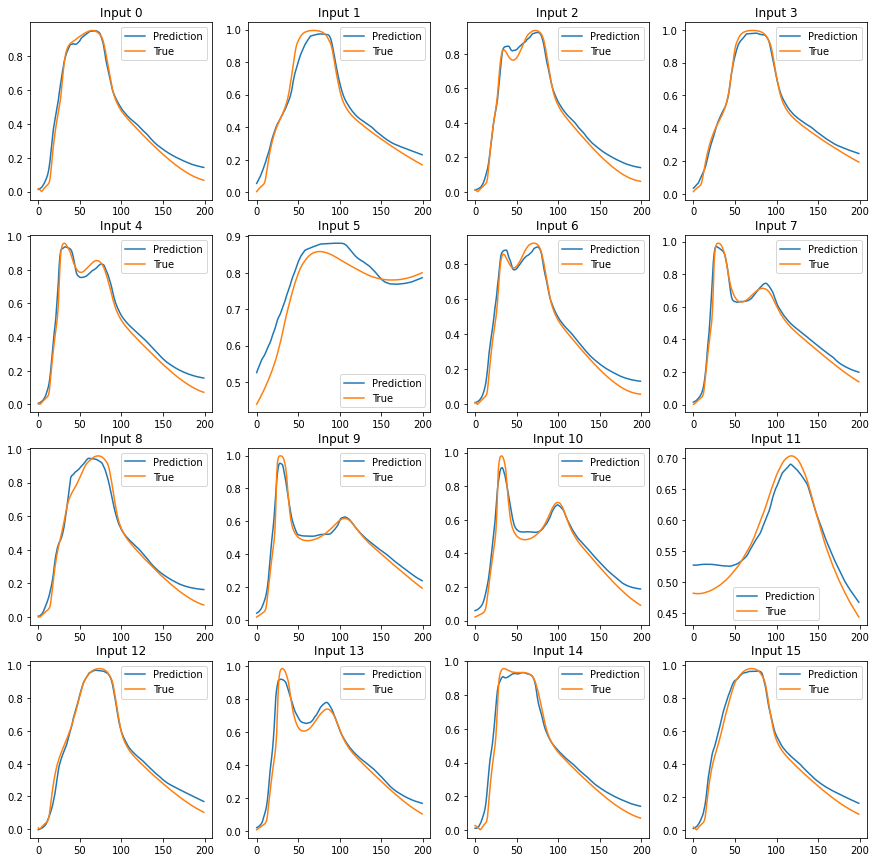

In [51]:
#@title Plot evaluation examples
fig, axs = plt.subplots(4, 4, figsize=(15,15))
axs = axs.flatten()
_size = 200
for i, ax in enumerate(axs):
    ax.plot(range(_size), predictions[i*_size:(i+1)*_size][:, 1], label="Prediction")
    ax.plot(range(_size), ys_test[i*_size:(i+1)*_size][:, 1], label="True")
    ax.legend()
    ax.set_title(f"Input {i}")

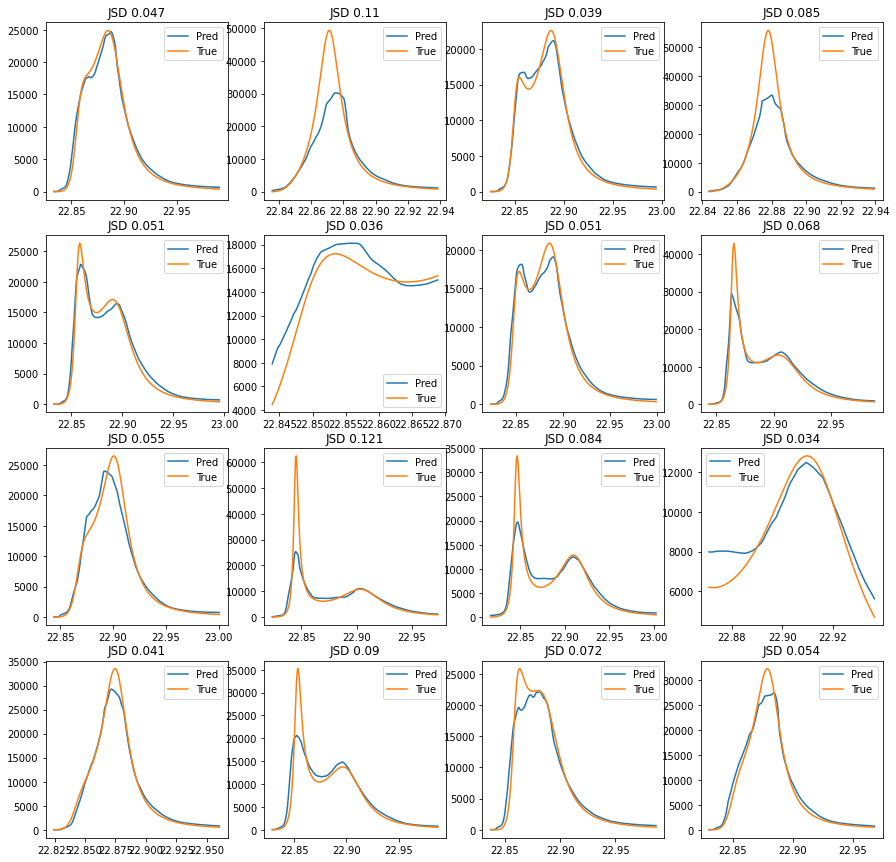

In [53]:
#@title Plot evaluation examples
from scipy.spatial.distance import jensenshannon as jsd

fig, axs = plt.subplots(4, 4, figsize=(15,15))
axs = axs.flatten()
_size = 200
for i, ax in enumerate(axs):
    xar = predi_truth[i*_size:(i+1)*_size][:, :-1].T[0]
    _pred = predi[i*_size:(i+1)*_size][:, 1]
    _tru = predi_truth[i*_size:(i+1)*_size][:, 1]
    ax.plot(xar, _pred, label="Pred")
    ax.plot(xar, _tru, label="True")
    ax.legend()
    ax.set_title(f"JSD {round(jsd(_tru, _pred),3)}")

## Let's try predicting at shifted points

In [127]:
np.tile(np.linspace(22.5, 23.5, 200), int(len(C[:, -1])/200))

array([22.5       , 22.50502513, 22.51005025, ..., 23.48994975,
       23.49497487, 23.5       ])

In [140]:
A = Xf_test.copy()
B = Xf_test.copy()
C = Xf_test.copy()
SHIFT = 0.02 # Shift in MHz
A[:, -1] = A[:, -1] + SHIFT
B[:, -1] = B[:, -1] - SHIFT
C[:, -1] = np.tile(np.linspace(22.7, 23.2, 200), int(len(C[:, -1])/200))

As = scalerX.transform(A) 
Bs = scalerX.transform(B) 
Cs = scalerX.transform(C) 

In [141]:
As_pred = model.predict(As)
As_predi = scalerY.inverse_transform(As_pred)

Bs_pred = model.predict(Bs)
Bs_predi = scalerY.inverse_transform(Bs_pred)

Cs_pred = model.predict(Cs)
Cs_predi = scalerY.inverse_transform(Cs_pred)

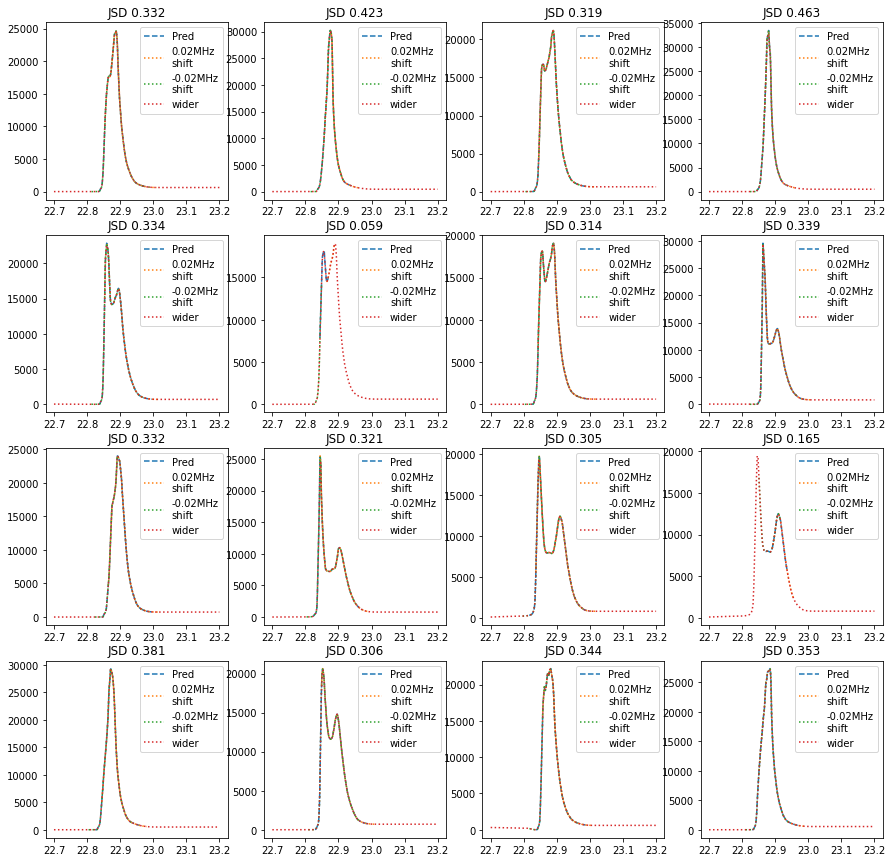

In [144]:
#@title Plot evaluation examples
from scipy.spatial.distance import jensenshannon as jsd

fig, axs = plt.subplots(4, 4, figsize=(15,15))
axs = axs.flatten()
_size = 200
for i, ax in enumerate(axs):
    xar = predi_truth[i*_size:(i+1)*_size][:, :-1].T[0]
    _pred = predi[i*_size:(i+1)*_size][:, 1]
    _shift = As_predi[i*_size:(i+1)*_size][:, 1]
    _shift_down = Bs_predi[i*_size:(i+1)*_size][:, 1]
    
    _general = Cs_predi[i*_size:(i+1)*_size][:, 1]
    xar2 = C[i*_size:(i+1)*_size][:, -1]
    
    ax.plot(xar, _pred, label="Pred", ls='--')
    ax.plot(xar + SHIFT, _shift, label=f"{SHIFT}MHz\nshift", ls=':')
    ax.plot(xar - SHIFT, _shift_down, label=f"-{SHIFT}MHz\nshift", ls=':')
    ax.plot(xar2, _general, label=f"wider", ls=':')
    ax.legend()
    #break
    ax.set_title(f"JSD {round(jsd(_shift, _pred),3)}")

### Widner/re-analytical

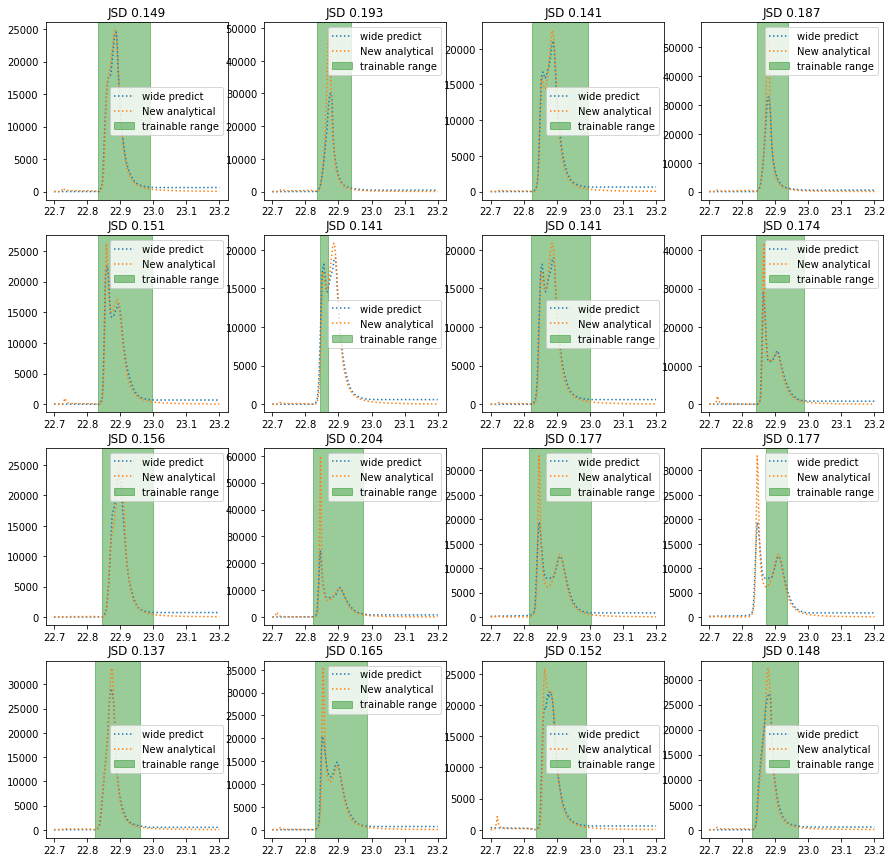

In [159]:
#@title Plot evaluation examples
from scipy.spatial.distance import jensenshannon as jsd

fig, axs = plt.subplots(4, 4, figsize=(15,15))
axs = axs.flatten()
_size = 200
for i, ax in enumerate(axs):
    xar = predi_truth[i*_size:(i+1)*_size][:, :-1].T[0]
    ax.axvspan(xar[0], xar[-1], label='trainable range', alpha=0.4, color='green')
    
    _general = Cs_predi[i*_size:(i+1)*_size][:, 1]
    xar2 = C[i*_size:(i+1)*_size][:, -1]
    cfg = C[i*_size, :-1]
    rederive = cm.sim.boost(xar2*1e9, cfg)
    
    ax.plot(xar2, _general, label=f"wide predict", ls=':')
    ax.plot(xar2, rederive, label=f"New analytical", ls=':')
    ax.legend()
    ax.set_title(f"JSD {round(jsd(_general, rederive),3)}")